##**Import Libraries**

In [1]:
%pip install nltk

In [2]:
import os
import csv
import nltk
import json
import joblib
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

##**Load Dataset**

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/AhlanAlghiff/Mental.ly-Project/refs/heads/Machine-Learning/dataset/Text%20Diagnose%20Dataset.csv")

In [5]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


##**Preprocessing Data & Text**

In [6]:
# Menghapus baris dengan status 'suicidal' berdasarkan kondisi
df = df.drop(df[df['status'] == 'Suicidal'].index)

print(df['status'].value_counts())

status
Normal                  16351
Depression              15404
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [7]:
# Remove 10,000 rows from 'Normal' and 'Depression' categories
df_normal = df[df['status'] == 'Normal'].iloc[10000:]
df_depression = df[df['status'] == 'Depression'].iloc[10000:]
df_others = df[~df['status'].isin(['Normal', 'Depression'])]
df = pd.concat([df_normal, df_depression, df_others])
df = df.reset_index(drop=True)

print(df['status'].value_counts())

status
Normal                  6351
Depression              5404
Anxiety                 3888
Bipolar                 2877
Stress                  2669
Personality disorder    1201
Name: count, dtype: int64


In [8]:
df.shape

(22390, 3)

In [9]:
df.isnull().sum()

,0
Unnamed: 0,0
statement,354
status,0


In [10]:
df = df.dropna()

In [11]:
df.shape

(22036, 3)

###**Preprocessing Text**

In [12]:
df['statement'] = df['statement'].str.lower()

df.head()

<ipython-input-12-c9b07b931599>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['statement'] = df['statement'].str.lower()


,Unnamed: 0,statement,status
0,32585,it passes inspection.,Normal
1,32586,here comes the waiter. see if his hands and na...,Normal
2,32587,"well, the waiter looked clean, so i guess it's...",Normal
3,32588,you're forgetting about the bathroom.,Normal
4,32589,i'm going to just hope that the bathroom is cl...,Normal


In [13]:
# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [14]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

In [15]:
df['statement'] = df['statement'].apply(preprocess_text)

df.head()

,Unnamed: 0,statement,status
0,32585,pass inspection,Normal
1,32586,come waiter see hand nail clean,Normal
2,32587,well waiter looked clean guess 's okay eat,Normal
3,32588,'re forgetting bathroom,Normal
4,32589,'m going hope bathroom clean,Normal


###**Label Encode**

In [16]:
# Memisahkan fitur dan label
statement = df['statement'].values
label = df['status'].values

In [17]:
# Encode label
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(label)

print(label_encoded)

[3 3 3 ... 0 0 0]


In [18]:
len(label_encoder.classes_)

6

##**Split Data**

In [19]:
# Pisahkan data
statement_train, statement_test, label_train, label_test = train_test_split(statement, label_encoded, test_size=0.2, random_state=42)

In [20]:
# Cek bentuk data setelah dibagi
print(statement_train.shape, statement_test.shape)
print(label_train.shape, label_test.shape)

(17628,) (4408,)
(17628,) (4408,)


##**Tokenizing**

In [21]:
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(statement_train)

In [22]:
word_index = tokenizer.word_index
print(len(word_index))

31114


In [23]:
# Menyimpan word_index kedalam sebuah file json

with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

In [24]:
train_sekuens = tokenizer.texts_to_sequences(statement_train)
test_sekuens = tokenizer.texts_to_sequences(statement_test)


train_padded = pad_sequences(train_sekuens,
                             maxlen=100,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=100,
                            padding='post',
                            truncating='post')

In [25]:
train_padded.shape


(17628, 100)

In [26]:
test_padded.shape

(4408, 100)

##**Modelling & Training**

In [27]:
model = Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=100),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
model.build((None, 100))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 443,814 (1.69 MB)

 Trainable params: 443,814 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Kompilasi model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# Latih model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
num_epochs = 30
history = model.fit(train_padded, label_train,
                    epochs=num_epochs,
                    batch_size=32,
                    validation_data=(test_padded, label_test),
                    callbacks=[early_stopping])

Epoch 1/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 166s 290ms/step - accuracy: 0.2939 - loss: 1.6708 - val_accuracy: 0.3816 - val_loss: 1.5189
Epoch 2/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 151s 274ms/step - accuracy: 0.3788 - loss: 1.5166 - val_accuracy: 0.4798 - val_loss: 1.3044
Epoch 3/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 194s 260ms/step - accuracy: 0.4741 - loss: 1.2699 - val_accuracy: 0.5159 - val_loss: 1.1665
Epoch 4/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 206s 267ms/step - accuracy: 0.4969 - loss: 1.1564 - val_accuracy: 0.5247 - val_loss: 1.1089
Epoch 5/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 190s 246ms/step - accuracy: 0.5219 - loss: 1.0931 - val_accuracy: 0.4789 - val_loss: 1.1277
Epoch 6/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 141s 245ms/step - accuracy: 0.5507 - loss: 1.0361 - val_accuracy: 0.6484 - val_loss: 0.9053
Epoch 7/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 146s 252ms/step - accuracy: 0.6821 - loss: 0.8367 - val_accuracy: 0.7189 - val_loss: 0.7962
Epoch 8/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 150s 267ms/step - accuracy: 0.7615 -

##**Evaluation**

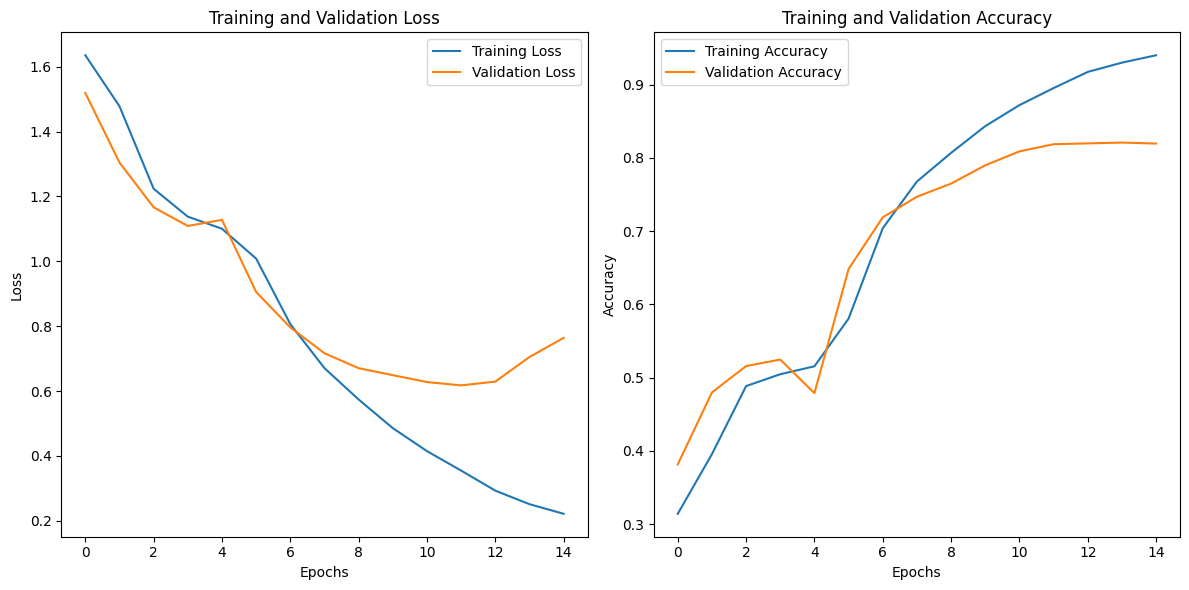

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

history_dict = history.history

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Prediksi menggunakan model
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = label_test

# Menampilkan classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step
                      precision    recall  f1-score   support

             Anxiety       0.82      0.76      0.79       762
             Bipolar       0.80      0.80      0.80       558
          Depression       0.83      0.81      0.82      1114
              Normal       0.96      0.96      0.96      1272
Personality disorder       0.66      0.54      0.59       210
              Stress       0.58      0.70      0.63       492

            accuracy                           0.82      4408
           macro avg       0.77      0.76      0.76      4408
        weighted avg       0.82      0.82      0.82      4408



##**Save Model**

##**Save Model as H5 and JS**

In [35]:
model.save("model.h5")

In [71]:
# Install tensorflowjs

# !pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [38]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file
